<a href="https://colab.research.google.com/github/huma1995/statistics/blob/main/Day_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Random Forest** (**Day 4**)

# **IMPORTANT!** Before we begin, change runtime type to R

### **1. Load in data**

In [16]:
exp_data <- read.csv('/content/X.csv', header=FALSE)
metadata <-read.csv('/content/obs.csv')
var_data<- read.csv('/content/var.csv')

rownames(exp_data)<-metadata$CellID
colnames(exp_data)<-var_data$Gene

### **2. Create Metadata and Expression data for the 3 cell types; Secretory Epithelial-1, Secretory Epithelial-2, STIC lesion**

In [4]:
install.packages("dplyr")
library(dplyr)
metadata_SE1 <- metadata[metadata$Celltype %in% c('Secretory Epithelial-1'),]
exp_data_SE1 <- exp_data[rownames(exp_data) %in% metadata_SE1$CellID,]

metadata_SE2 <- metadata[metadata$Celltype %in% c('Secretory Epithelial-2'),]
exp_data_SE2 <- exp_data[rownames(exp_data) %in% metadata_SE2$CellID,]

metadata_STIC <- metadata[metadata$Celltype %in% c('STIC lesion'),]
exp_data_STIC <- exp_data[rownames(exp_data) %in% metadata_STIC$CellID,]

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




### **3. Analyse disease stages in each cell type and select a cell type for analysis and the disease stage for prediction**

In [5]:
install.packages("tibble")
library(tibble)
#random forest to predict disease stage
table(metadata_SE1$Disease_stage)
table(metadata_SE2$Disease_stage)
table(metadata_STIC$Disease_stage)

#subset expression data in SE2 into disease stages
exp_data$CellID <- rownames(exp_data)
exp_data_SE2 <- merge(metadata_SE2[,c('CellID','Disease_stage')],exp_data, by='CellID')
exp_data_SE2$Disease_stage[exp_data_SE2$Disease_stage %in% c('Benign','I','IIIc','IIIc1')] <- c('Rest')
library(tibble)
exp_data_SE2 <- tibble::column_to_rownames(exp_data_SE2, "CellID")


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)




Benign      I   IIIc  IIIc1     IV 
  1059      3     26     17     23 


Benign      I   IIIc  IIIc1     IV 
   106    195    411    288    614 


    I  IIIc IIIc1    IV 
  210    20    27    45 

### **4. Smote**


**SMOTE (Synthetic Minority Over-sampling Technique)**: A method used to address the issue of imbalanced datasets in machine learning. It helps balance the classes by creating synthetic examples of the minority class rather than simply duplicating existing ones. This makes the dataset more suitable for training machine learning models, which often perform poorly on imbalanced datasets.

In [6]:
install.packages("performanceEstimation")
library(performanceEstimation)

exp_data_SE2$Disease_stage <- as.factor(exp_data_SE2$Disease_stage)

table(exp_data_SE2$Disease_stage)
exp_data_SE2_smoted <- performanceEstimation::smote(Disease_stage~.,exp_data_SE2, perc.over = 0.5, perc.under =3 )
table(exp_data_SE2_smoted$Disease_stage)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘BBmisc’, ‘checkmate’, ‘parallelMap’





  IV Rest 
 614 1000 


  IV Rest 
 921  921 

### **5. Random Forest**

Random Forest is a versatile and widely used machine learning algorithm that combines the power of multiple decision trees to create a robust and accurate predictive model. It is a type of ensemble learning, where multiple models are trained and combined to improve performance and reduce overfitting.


**Create a testing and training set from the expression data of a cell type.**

The training set and test set are critical components of the process used to train and evaluate the model. They ensure that the model learns effectively from the data and can generalize well to unseen examples.

**Training Set**: The training set is the subset of the data used to build (train) the random forest model.
- The algorithm uses the training set to create individual decision trees.
- Each tree is trained on a bootstrap sample of the training set, which is a random sample with replacement. This introduces diversity among the trees.
- The training process includes:
Splitting the data into branches based on feature values.
Calculating measures like Gini impurity or information gain to choose the best splits.
- On average, about 2/3 of the training data is used to train each tree, while the remaining is left out. These left-out samples are called the Out-Of-Bag (OOB) data.

**Testing Set**: The test set is a separate subset of the data, not used during the training phase. It is used to evaluate the performance of the random forest on unseen data.

Here, 70% of our dataset is used for the training set and 30% as the test set.

In [7]:
#Random Forest - training and test set
colnames(exp_data_SE2_smoted) <- gsub('-','_',colnames(exp_data_SE2_smoted))
selected.samples<-sample(c(1:nrow(exp_data_SE2_smoted)),size = nrow(exp_data_SE2_smoted)*0.7)
train.data<-exp_data_SE2_smoted[selected.samples,]
test.data<-exp_data_SE2_smoted[-selected.samples,]

**Carry out Boruta**

Boruta: Package to identify which features are most relevant for predicting a target variable.

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘RcppEigen’, ‘ranger’




Boruta performed 99 iterations in 16.42172 mins.
 186 attributes confirmed important: ABI3BP, ACTC1, ACTG1P4, ACTG2,
ADAM28 and 181 more;
 5472 attributes confirmed unimportant: A2M, A2M_AS1, A2ML1, AACS,
AADAT and 5467 more;
 193 tentative attributes left: ACER3, ACP6, AGR2, AHCY, AJUBA and 188
more;

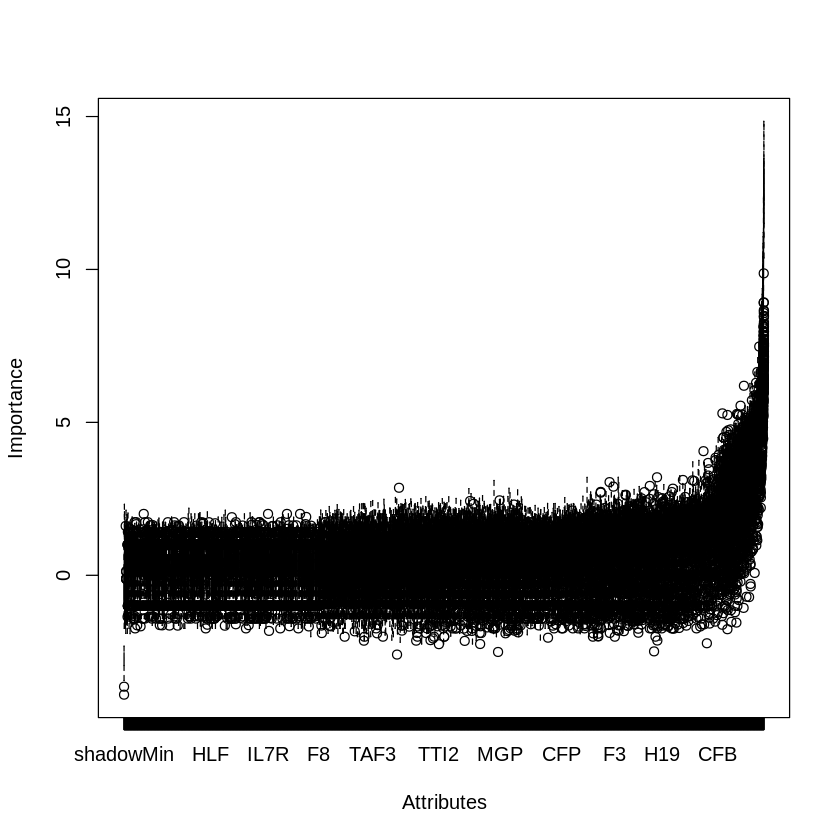

In [8]:
install.packages("Boruta")
library(Boruta)
bor<-Boruta(Disease_stage~.,data=train.data)
plot(bor)
bor
bor_confirmed <- data.frame(bor$finalDecision[bor$finalDecision %in% "Confirmed"])
bor_confirmed <- rownames(bor_confirmed)

**Random Forest Model**

In [9]:
install.packages("randomForest")
library(randomForest)
set.seed(1)  # Setting seed
rf<-randomForest(Disease_stage~.,data=train.data, ntree = 500)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

randomForest 4.7-1.2

Type rfNews() to see new features/changes/bug fixes.


Attaching package: ‘randomForest’


The following object is masked from ‘package:dplyr’:

    combine




**Plotting the OOB error rate of the model and gini Coefficient.**

The error rate in a random forest quantifies how often the model makes incorrect predictions. It reflects the model's ability to generalize to unseen data and is a critical metric for evaluating its performance. OOB Error is a built-in mechanism of random forest that acts as an internal validation set without the need for a separate test set.

**Gini Coefficient**: Gini coefficient, which is a measure of inequality or impurity in classification problems. Here it is represented in the form of the Mean Decrease Gini which measures the importance of each feature based on how much it contributes to reducing Gini impurity during the construction of the decision tree.

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)


Attaching package: ‘ggplot2’


The following object is masked from ‘package:randomForest’:

    margin




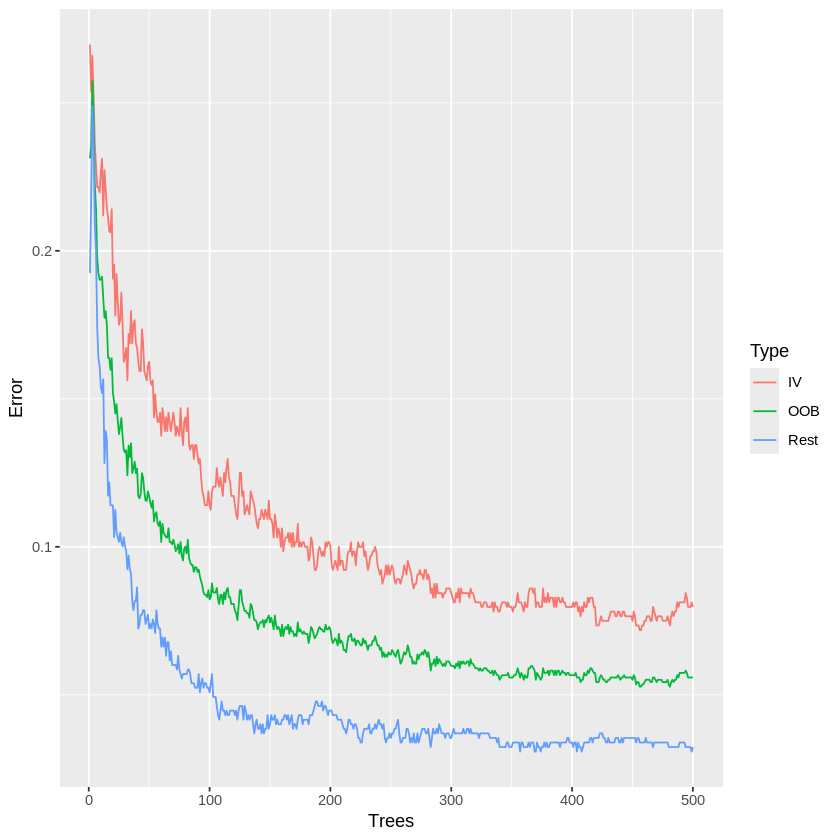

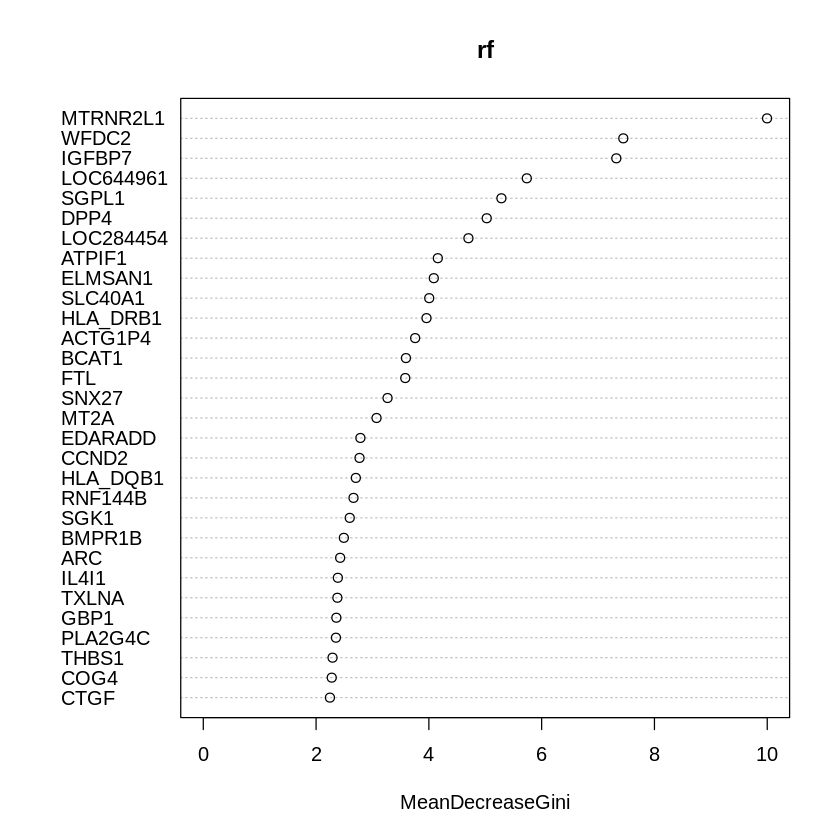

In [10]:
install.packages("ggplot2")
library(ggplot2)
oob.error.data <- data.frame(Trees = rep(1:nrow(rf$err.rate), times=3),
                             Type = rep(c("OOB","IV","Rest"), each=nrow(rf$err.rate)),
                             Error = c(rf$err.rate[,"OOB"],
                                       rf$err.rate[,"IV"],
                                       rf$err.rate[,"Rest"]))
ggplot(data = oob.error.data,aes(x=Trees, y=Error))+
  geom_line(aes(color=Type))

# Variable importance plot
varImpPlot(rf)

**Calculating the Out-of-Bag (OOB) Area under curve (AUC) from the model**

**AUC:** The AUC measures the ability of a random forest classifier to distinguish between classes. The AUC refers to the area under the Receiver Operating Characteristic (ROC) curve, which is a graphical representation of a classifier’s performance across different classification thresholds.

The value of AUC ranges from 0 to 1:
- AUC = 0.5: The model performs no better than random guessing.
- AUC = 1.0: The model perfectly distinguishes between positive and negative classes.
- AUC < 0.5: The model is performing worse than random guessing.

**Receiver Operating Characteristic (ROC)**: For each possible threshold (ranging from 0 to 1), the random forest classifier computes the True Positive Rate and False Positive Rate.
By plotting these values for each threshold, you create the ROC curve.



Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘bitops’, ‘gtools’, ‘caTools’, ‘gplots’




[1] 0.9911318

OOB 
0.05585725

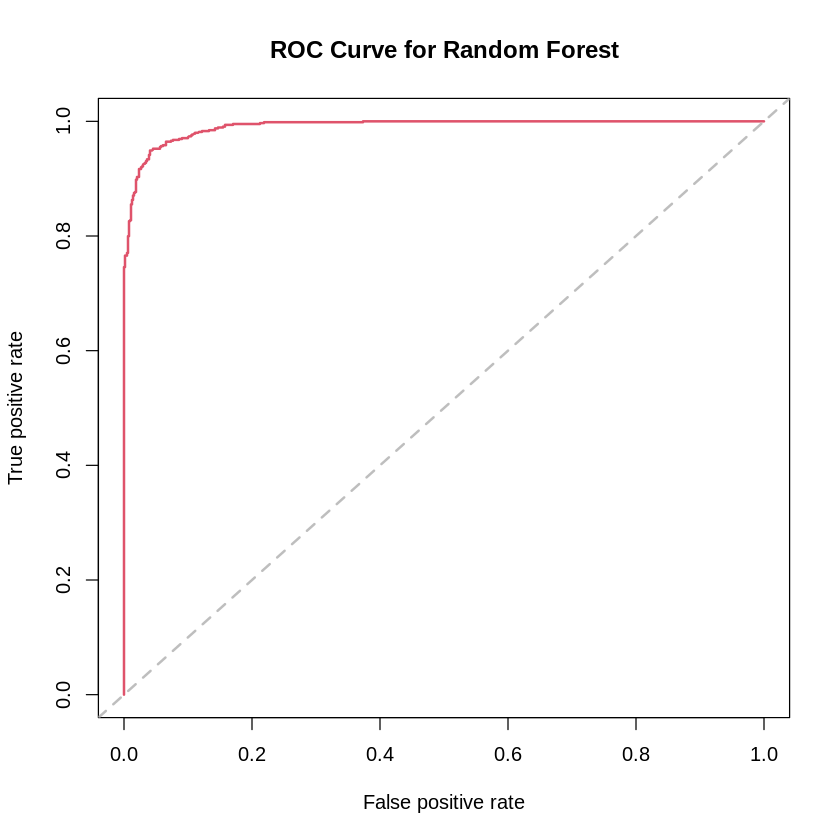

In [11]:
install.packages("ROCR")
library(ROCR)
#OOB AUC
pred1=predict(rf,type = "prob")
perf = prediction(as.numeric(pred1[,2]),train.data$Disease_stage)
# 1. Area under curve
auc = performance(perf, "auc")
auc <- as.numeric(auc@y.values)
auc
rf$err.rate[nrow(rf$err.rate),1]
# 2. True Positive and Negative Rate
pred3 = performance(perf, "tpr","fpr")
# 3. Plot the ROC curve
plot(pred3,main="ROC Curve for Random Forest",col=2,lwd=2)
abline(a=0,b=1,lwd=2,lty=2,col="gray")

**Validation Analysis on testing dataset**

In [12]:
install.packages("caret")
library(caret)
# Validation cohort
pred<-predict(rf,test.data)
confusionMatrix(pred,test.data$Disease_stage)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘listenv’, ‘parallelly’, ‘future’, ‘globals’, ‘shape’, ‘future.apply’, ‘numDeriv’, ‘progressr’, ‘SQUAREM’, ‘diagram’, ‘lava’, ‘prodlim’, ‘proxy’, ‘iterators’, ‘clock’, ‘gower’, ‘hardhat’, ‘ipred’, ‘timeDate’, ‘e1071’, ‘foreach’, ‘ModelMetrics’, ‘plyr’, ‘pROC’, ‘recipes’, ‘reshape2’


Loading required package: lattice



Confusion Matrix and Statistics

          Reference
Prediction  IV Rest
      IV   266    6
      Rest  15  266
                                          
               Accuracy : 0.962           
                 95% CI : (0.9425, 0.9763)
    No Information Rate : 0.5081          
    P-Value [Acc > NIR] : < 2e-16         
                                          
                  Kappa : 0.9241          
                                          
 Mcnemar's Test P-Value : 0.08086         
                                          
            Sensitivity : 0.9466          
            Specificity : 0.9779          
         Pos Pred Value : 0.9779          
         Neg Pred Value : 0.9466          
             Prevalence : 0.5081          
         Detection Rate : 0.4810          
   Detection Prevalence : 0.4919          
      Balanced Accuracy : 0.9623          
                                          
       'Positive' Class : IV              
                           

[1] 0.9941451

OOB 
0.05585725

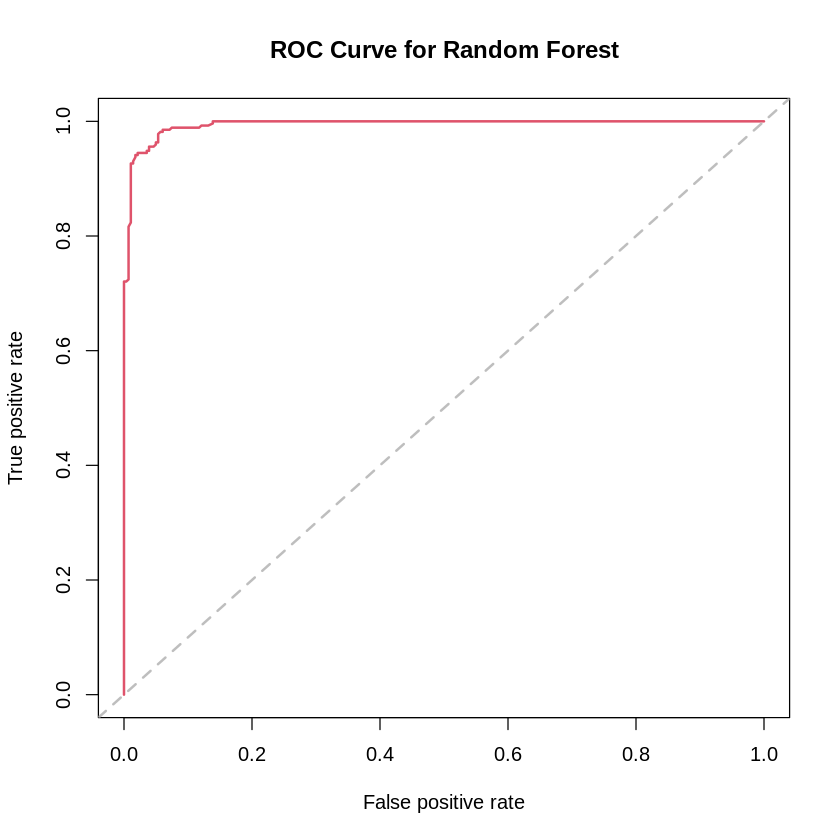

In [13]:
#Validation AUC
pred1=predict(rf,newdata = test.data,type = "prob")
perf = prediction(pred1[,2],test.data$Disease_stage)
# 1. Area under curve
auc = performance(perf, "auc")
auc <- as.numeric(auc@y.values)
auc
rf$err.rate[nrow(rf$err.rate),1]
# 2. True Positive and Negative Rate
pred3 = performance(perf, "tpr","fpr")
# 3. Plot the ROC curve
plot(pred3,main="ROC Curve for Random Forest",col=2,lwd=2)
abline(a=0,b=1,lwd=2,lty=2,col="gray")


# **Your Try**

Select a disease stage for analysis. Replace "choice" to selected disease stage.

In [26]:
#view table of disease stages in each cell type
table(metadata_SE1$Disease_stage)
table(metadata_SE2$Disease_stage)
table(metadata_STIC$Disease_stage)

#subset expression data in STIC into disease stages
exp_data$CellID <- rownames(exp_data)
exp_data_STIC <- merge(metadata_STIC[,c('CellID','Disease_stage')],exp_data, by='CellID')
exp_data_STIC$Disease_stage[exp_data_STIC$Disease_stage %in% c('Benign','I','IIIc','IIIc1')] <- c('Rest')
library(tibble)
exp_data_STIC <- tibble::column_to_rownames(exp_data_STIC, "CellID")


Benign      I   IIIc  IIIc1     IV 
  1059      3     26     17     23 


Benign      I   IIIc  IIIc1     IV 
   106    195    411    288    614 


    I  IIIc IIIc1    IV 
  210    20    27    45 

Fill in perc.over and perc.under arguments to balance your data

In [23]:
install.packages("performanceEstimation")
library(performanceEstimation)



Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [27]:
table(exp_data_STIC$Disease_stage)


  IV Rest 
  45  257 

In [30]:
exp_data_STIC$Disease_stage <- as.factor(exp_data_STIC$Disease_stage)

table(exp_data_STIC$Disease_stage)
exp_data_STIC_smoted <- performanceEstimation::smote(Disease_stage~.,exp_data_STIC, perc.over = 1, perc.under =3)
table(exp_data_STIC_smoted$Disease_stage)


  IV Rest 
  45  257 


  IV Rest 
  90  135 

Boruta performed 99 iterations in 45.92561 secs.
 79 attributes confirmed important: ALCAM, ARC, ARSA, ATPIF1, ATXN1 and
74 more;
 5682 attributes confirmed unimportant: A2M, A2M_AS1, A2ML1, AACS,
AADAT and 5677 more;
 90 tentative attributes left: ABCC4, ACSL5, ACVR2B, ALDH1A3, ALS2CL
and 85 more;

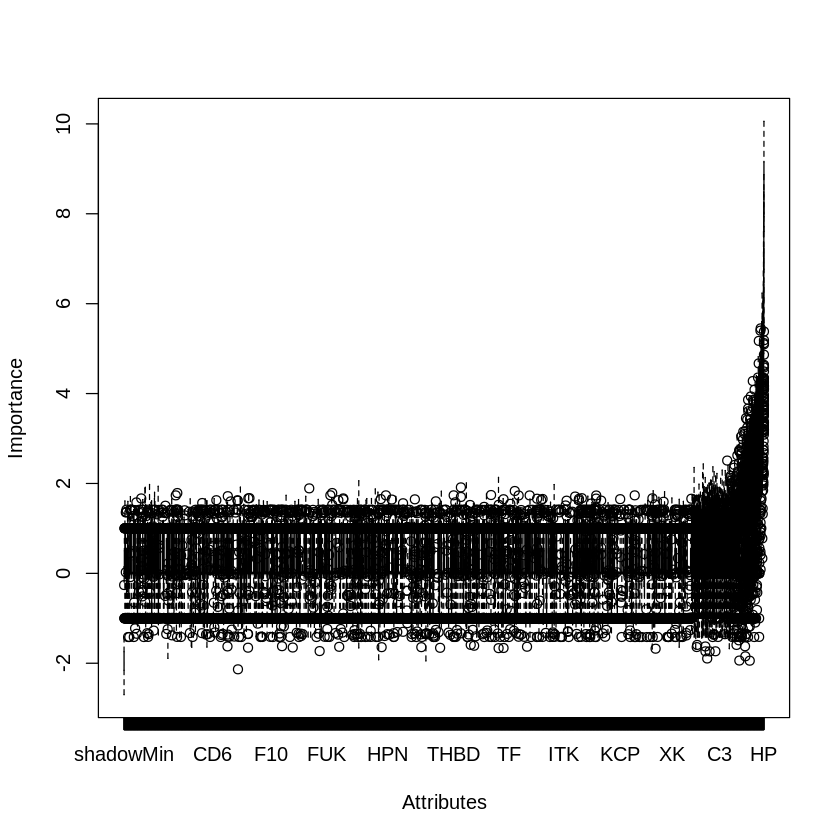

In [32]:
#Random Forest - training and test set
colnames(exp_data_STIC_smoted) <- gsub('-','_',colnames(exp_data_STIC_smoted))
selected.samples<-sample(c(1:nrow(exp_data_STIC_smoted)),size = nrow(exp_data_STIC_smoted)*0.7)
train.data<-exp_data_STIC_smoted[selected.samples,]
test.data<-exp_data_STIC_smoted[-selected.samples,]

bor<-Boruta(Disease_stage~.,data=train.data)
plot(bor)
bor
bor_confirmed <- data.frame(bor$finalDecision[bor$finalDecision %in% "Confirmed"])
bor_confirmed <- rownames(bor_confirmed)

In [33]:
set.seed(2)  # Setting seed
rf<-randomForest(Disease_stage~.,data=train.data, ntree = 500)

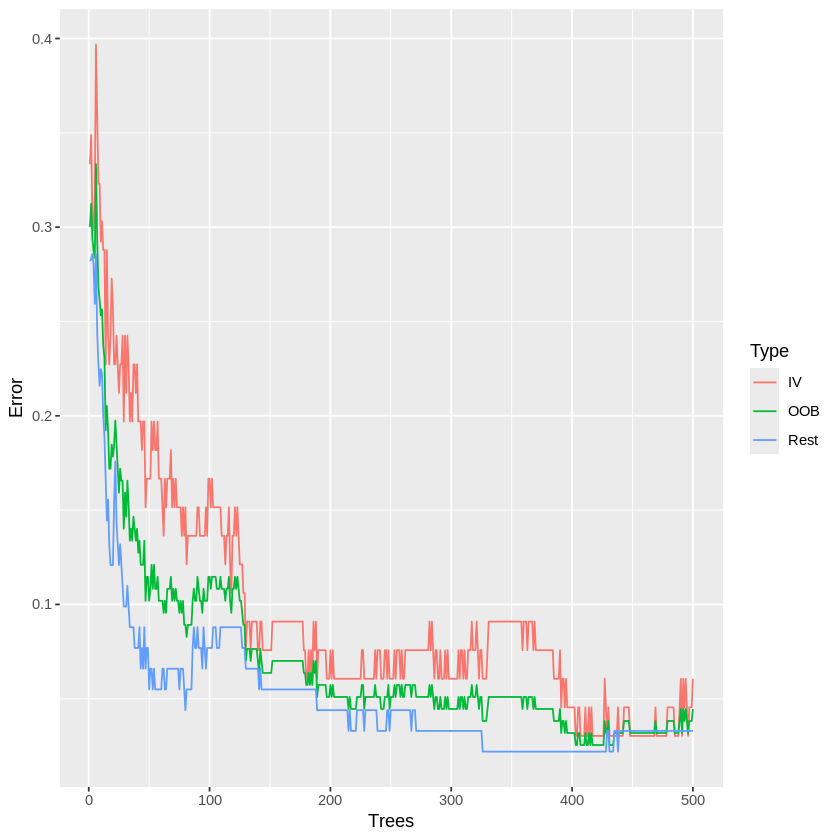

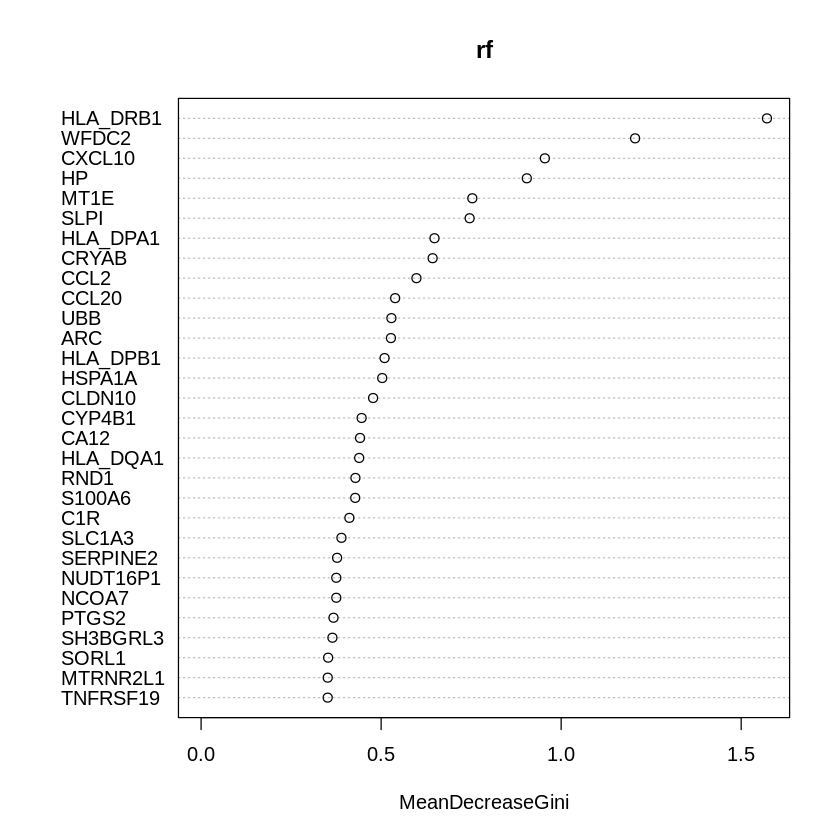

In [35]:
oob.error.data <- data.frame(Trees = rep(1:nrow(rf$err.rate), times=3),
                             Type = rep(c("OOB","IV","Rest"), each=nrow(rf$err.rate)),
                             Error = c(rf$err.rate[,"OOB"],
                                       rf$err.rate[,"IV"],
                                       rf$err.rate[,"Rest"]))
ggplot(data = oob.error.data,aes(x=Trees, y=Error))+
  geom_line(aes(color=Type))

# Variable importance plot
varImpPlot(rf)

[1] 0.995338

OOB 
0.04458599

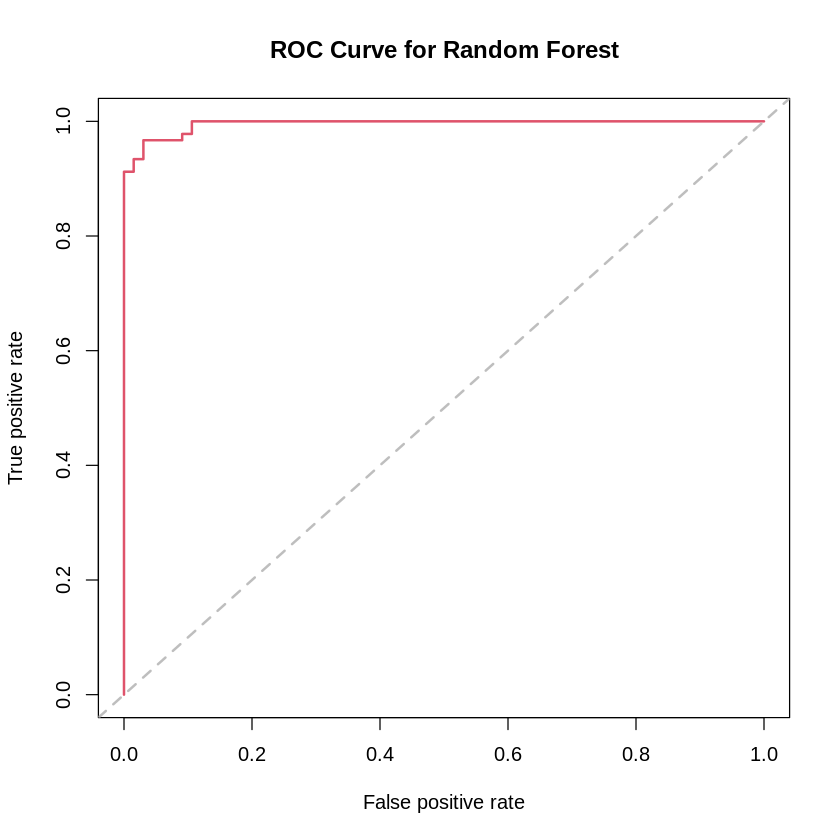

In [36]:
#OOB AUC
pred1=predict(rf,type = "prob")
perf = prediction(as.numeric(pred1[,2]),train.data$Disease_stage)
# 1. Area under curve
auc = performance(perf, "auc")
auc <- as.numeric(auc@y.values)
auc
rf$err.rate[nrow(rf$err.rate),1]
# 2. True Positive and Negative Rate
pred3 = performance(perf, "tpr","fpr")
# 3. Plot the ROC curve
plot(pred3,main="ROC Curve for Random Forest",col=2,lwd=2)
abline(a=0,b=1,lwd=2,lty=2,col="gray")

In [37]:
# Validation cohort
pred<-predict(rf,test.data)
confusionMatrix(pred,test.data$Disease_stage)

Confusion Matrix and Statistics

          Reference
Prediction IV Rest
      IV   23    0
      Rest  1   44
                                          
               Accuracy : 0.9853          
                 95% CI : (0.9208, 0.9996)
    No Information Rate : 0.6471          
    P-Value [Acc > NIR] : 5.309e-12       
                                          
                  Kappa : 0.9675          
                                          
 Mcnemar's Test P-Value : 1               
                                          
            Sensitivity : 0.9583          
            Specificity : 1.0000          
         Pos Pred Value : 1.0000          
         Neg Pred Value : 0.9778          
             Prevalence : 0.3529          
         Detection Rate : 0.3382          
   Detection Prevalence : 0.3382          
      Balanced Accuracy : 0.9792          
                                          
       'Positive' Class : IV              
                              

[1] 0.999053

OOB 
0.04458599

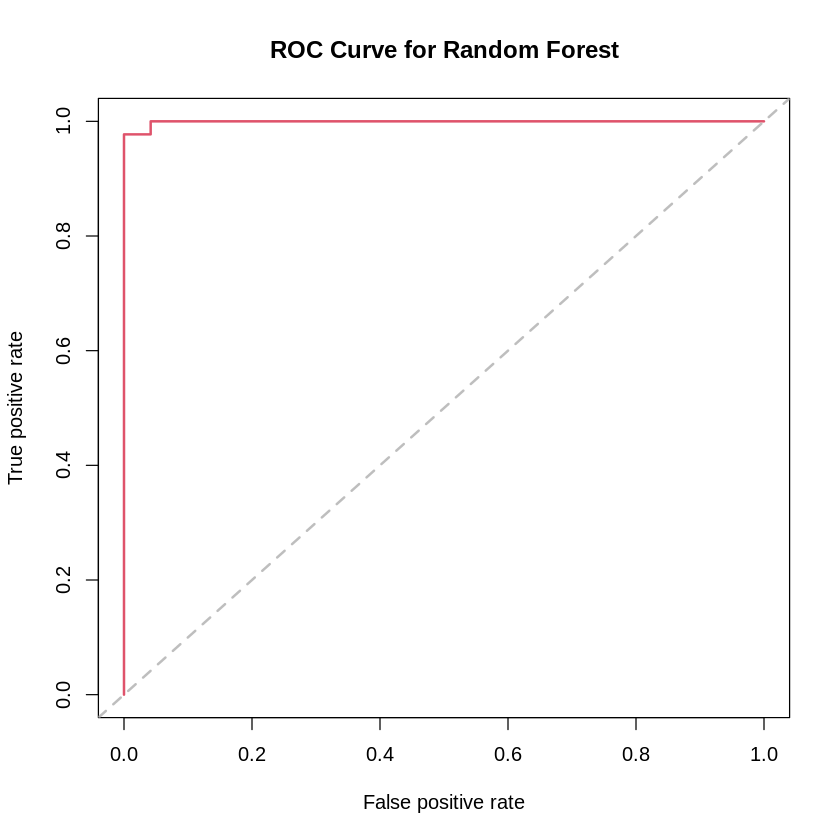

In [38]:
#Validation AUC
pred1=predict(rf,newdata = test.data,type = "prob")
perf = prediction(pred1[,2],test.data$Disease_stage)
# 1. Area under curve
auc = performance(perf, "auc")
auc <- as.numeric(auc@y.values)
auc
rf$err.rate[nrow(rf$err.rate),1]
# 2. True Positive and Negative Rate
pred3 = performance(perf, "tpr","fpr")
# 3. Plot the ROC curve
plot(pred3,main="ROC Curve for Random Forest",col=2,lwd=2)
abline(a=0,b=1,lwd=2,lty=2,col="gray")